# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [3]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2017-06-12/data_eval_new/"
file_name = "int_norm_20170612_bgd_new_den.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [4]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [5]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [6]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

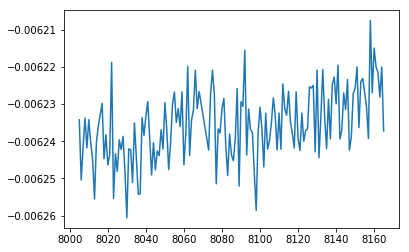

In [10]:
# Check Baselines
column = "119"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

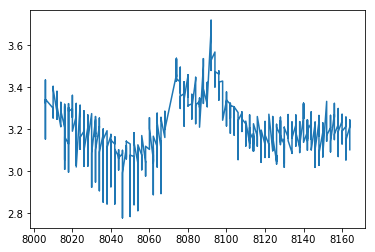

In [541]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

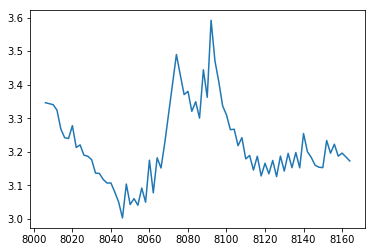

In [542]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

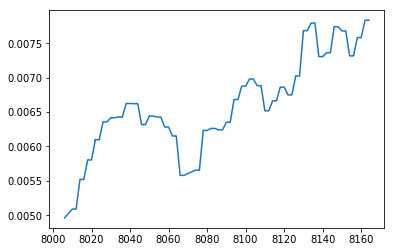

In [543]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [544]:
background_mean = df_mean(background)

# Outlier rejection

In [601]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_118_120"
interf_corr = "Te125_Xe129_corr"

In [602]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [603]:
column = "124/120"
sample = "NIST 200ppb"

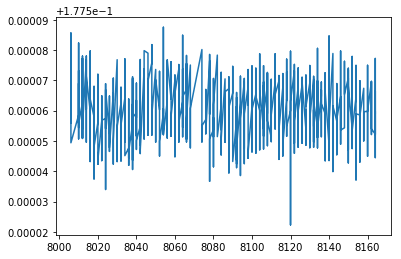

In [604]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [605]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [606]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2017-06-12 18:56:00,NIST 200ppb,2,1,8006,0.029827,0.020199,0.010359,0.445979,0.235334,0.742935,0.263502,0.142089,0.177566
2017-06-12 18:56:00,NIST 200ppb,2,2,8006,0.029828,0.020194,0.010362,0.445997,0.235340,0.742935,0.263498,0.142086,0.177556
2017-06-12 18:56:00,NIST 200ppb,2,3,8006,0.029825,0.020192,0.010362,0.446001,0.235346,0.742935,0.263503,0.142088,0.177557
2017-06-12 18:56:00,NIST 200ppb,2,4,8006,0.029824,0.020194,0.010364,0.445998,0.235331,0.742935,0.263515,0.142099,0.177585
2017-06-12 18:56:00,NIST 200ppb,2,5,8006,0.029824,0.020193,0.010361,0.445981,NaN,0.742935,0.263510,0.142097,0.177566
2017-06-12 18:56:00,NIST 200ppb,2,6,8006,0.029821,0.020189,0.010361,0.445973,0.235338,0.742935,0.263505,0.142092,0.177574
2017-06-12 18:56:00,NIST 200ppb,2,7,8006,0.029827,0.020193,0.010362,0.445990,0.235343,0.742935,0.263498,0.142091,0.177562
2017-06-12 18:56:00,NIST 200ppb,2,8,8006,0.029822,0.020191,0.010363,0.445982,0.235337,0.742935,0.263507,0.142095,0.177568
2017-06-12 18:56:00,NIST 200ppb,2,9,8006,0.029818,0.020188,0.010364,0.445992,0.235343,0.742935,0.263507,0.142085,0.177564


In [607]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
8008        2017-06-12 19:21:00    0.186864
8016        2017-06-12 21:08:00    0.186794
8027        2017-06-12 23:35:00    0.186855
8030        2017-06-13 00:15:00    0.186895
8031        2017-06-13 00:29:00    0.186922
8036        2017-06-13 01:37:00    0.186889
8040        2017-06-13 02:31:00    0.186973
            2017-06-13 02:31:00    0.186973
            2017-06-13 02:31:00    0.186913
8046        2017-06-13 03:50:00    0.187067
8050        2017-06-13 04:44:00    0.187074
8052        2017-06-13 05:12:00    0.187078
8064        2017-06-13 07:53:00    0.186929
8076        2017-06-13 11:03:00    0.186855
8079        2017-06-13 11:43:00    0.186895
            2017-06-13 11:43:00    0.186959
8092        2017-06-13 14:38:00    0.186786
8103        2017-06-13 17:05:00    0.186967
8104        2017-06-13 17:20:00    0.187009
            2017-06-13 17:20:00    0.187008
            2017-06-13 17:20:00    0.187009
8116        2017-06-13 20:01:00    0.187049


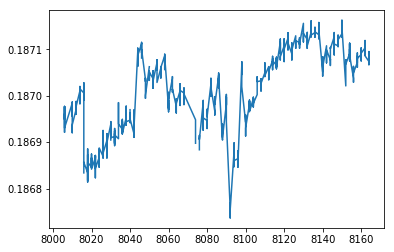

In [608]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [609]:
df[df["Sample"] == sample][column].std()

8.769496039605578e-05

In [610]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

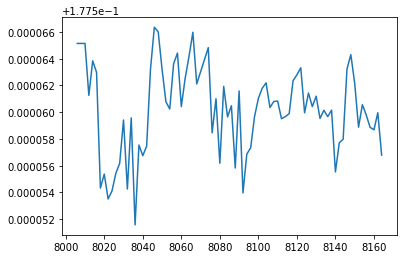

In [611]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [612]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,
2017-06-12 18:56:00,8006,NIST 200ppb,0.029824,0.020192,0.010363,0.445991,0.235339,0.742935,0.263505,0.142092,0.177565
2017-06-12 19:21:00,8008,NIST 350ppb,0.029824,0.020191,0.010362,0.446004,0.235343,0.742935,0.263506,0.142097,0.177568
2017-06-12 19:46:00,8010,NIST 200ppb,0.029824,0.020191,0.010362,0.445994,0.235337,0.742935,0.263500,0.142094,0.177565
2017-06-12 20:01:00,8011,NIST 350ppb,0.029825,0.020192,0.010362,0.446005,0.235340,0.742935,0.263504,0.142095,0.177568
2017-06-12 20:15:00,8012,NIST 200ppb,0.029825,0.020191,0.010363,0.445995,0.235337,0.742935,0.263499,0.142093,0.177561
2017-06-12 20:40:00,8014,NIST 200ppb,0.029825,0.020194,0.010362,0.446000,0.235336,0.742935,0.263498,0.142092,0.177564
2017-06-12 20:54:00,8015,NIST 200ppb + 2ppb Mo,0.029825,0.020192,0.010362,0.446001,0.235339,0.742935,0.263498,0.142090,0.177561
2017-06-12 21:08:00,8016,NIST 200ppb,0.029821,0.020190,0.010362,0.445997,0.235336,0.742935,0.263497,0.142091,0.177563
2017-06-12 21:34:00,8018,NIST 200ppb,0.029821,0.020192,0.010361,0.446002,0.235337,0.742935,0.263497,0.142088,0.177554


In [613]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [614]:
drop_sum = []

In [615]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [616]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [617]:
data_mean_int_sum

112/120                       114/120  \
                                mean           SD2 count      mean   
Sample                                                               
J.W. Leach 3a Aliq. 2 bomb  0.029823           NaN     1  0.020191   
J.W. bomb 1_1 + 1_2         0.029823           NaN     1  0.020191   
NIST 200ppb                 0.029825  4.077741e-06    77  0.020192   
NIST 200ppb + 0.005ppb U    0.029826  8.543603e-06     2  0.020194   
NIST 200ppb + 0.015ppb U    0.029828           NaN     1  0.020195   
NIST 200ppb + 0.030ppb Cd   0.029828  6.645008e-06     2  0.020197   
NIST 200ppb + 0.04ppb Cd    0.029827  2.993109e-07     2  0.020196   
NIST 200ppb + 0.100ppb Zr   0.029824  8.813401e-06     2  0.020192   
NIST 200ppb + 0.150ppb Rh   0.029825  6.592329e-06     2  0.020193   
NIST 200ppb + 0.300ppb Ru   0.029824  2.923137e-06     2  0.020192   
NIST 200ppb + 0.50ppb Pd    0.029824  5.903912e-06     2  0.020192   
NIST 200ppb + 0.628ppb Te   0.029827  3.577695e-06     2  0.020192   
NIST 200ppb + 2ppb Mo       0.029825  1.381691e-06     2  0.020191   
NIST 200ppb + 30ppb Ca      0.029824  4.034439e-07     2  0.020192   
NIST 200ppb + 65ppb Cr      0.029826  4.000658e-06     2  0.020193   
NIST 200ppb + ME            0.029828  6.668941e-07     2  0.020197   
NIST 350ppb                 0.029826  3.773513e-06    11  0.020193   
ZH09-05 23.3_3b_3 Aliq. 5   0.029828           NaN     1  0.020196   

                                                 115/120                      \
                                     SD2 count      mean           SD2 count   
Sample                                                                         
J.W. Leach 3a Aliq. 2 bomb           NaN     1  0.010361           NaN     1   
J.W. bomb 1_1 + 1_2                  NaN     1  0.010362           NaN     1   
NIST 200ppb                 2.838801e-06    77  0.010363  1.283861e-06    77   
NIST 200ppb + 0.005ppb U    2.773258e-06     2  0.010363  1.042659e-06     2   
NIST 200ppb + 0.015ppb U             NaN     1  0.010362           NaN     1   
NIST 200ppb + 0.030ppb Cd   9.790948e-07     2  0.010362  9.456273e-07     2   
NIST 200ppb + 0.04ppb Cd    2.361979e-06     2  0.010364  6.251992e-07     2   
NIST 200ppb + 0.100ppb Zr   5.359966e-06     2  0.010362  2.164811e-07     2   
NIST 200ppb + 0.150ppb Rh   4.116806e-06     2  0.010363  4.866584e-08     2   
NIST 200ppb + 0.300ppb Ru   3.613804e-06     2  0.010362  6.794874e-08     2   
NIST 200ppb + 0.50ppb Pd    1.999525e-07     2  0.010363  2.197849e-08     2   
NIST 200ppb + 0.628ppb Te   9.405459e-08     2  0.010363  4.379577e-07     2   
NIST 200ppb + 2ppb Mo       1.001006e-06     2  0.010362  7.618821e-07     2   
NIST 200ppb + 30ppb Ca      1.298441e-06     2  0.010363  9.200817e-09     2   
NIST 200ppb + 65ppb Cr      3.610013e-06     2  0.010363  1.381504e-06     2   
NIST 200ppb + ME            3.844773e-06     2  0.010364  1.059306e-06     2   
NIST 350ppb                 1.645801e-06    11  0.010363  1.023662e-06    11   
ZH09-05 23.3_3b_3 Aliq. 5            NaN     1  0.010362           NaN     1   

                             116/120  ...  118/120   119/120                  \
                                mean  ...    count      mean       SD2 count   
Sample                                ...                                      
J.W. Leach 3a Aliq. 2 bomb  0.445994  ...        1  0.263489       NaN     1   
J.W. bomb 1_1 + 1_2         0.445999  ...        1  0.263489       NaN     1   
NIST 200ppb                 0.446000  ...       77  0.263491  0.000008    77   
NIST 200ppb + 0.005ppb U    0.445998  ...        2  0.263495  0.000016     2   
NIST 200ppb + 0.015ppb U    0.446000  ...        1  0.263498       NaN     1   
NIST 200ppb + 0.030ppb Cd   0.446003  ...        2  0.263492  0.000013     2   
NIST 200ppb + 0.04ppb Cd    0.446002  ...        2  0.263493  0.000007     2   
NIST 200ppb + 0.100ppb Zr   0.445996  ...        2  0.263494  0.000009     2 

In [618]:
date_list = [pd.Timestamp("2017-06-13 14:10:00")]


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)

In [619]:
epsilon_int_200

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2017-06-12 18:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST 200ppb
2017-06-12 19:21:00,0.000000,0.026733,-0.072785,-0.013823,0.264478,0.196055,-1.110223e-12,0.109426,0.287345,0.132681,NIST 350ppb
2017-06-12 19:46:00,1.248595,-0.122555,-0.238513,-0.418183,0.025175,-0.024381,2.220446e-12,-0.072334,0.115654,0.109380,NIST 200ppb
2017-06-12 20:01:00,0.000000,0.183308,0.701784,-0.161641,0.232509,0.111291,2.220446e-12,0.177717,0.121674,0.248533,NIST 350ppb
2017-06-12 20:15:00,0.000000,0.108785,-0.500259,0.464981,-0.050019,0.002998,-1.110223e-12,-0.017375,-0.001152,-0.182108,NIST 200ppb
2017-06-12 20:40:00,0.000000,0.683506,1.524060,-0.400879,0.092837,-0.018393,0.000000e+00,0.000209,0.006136,0.097121,NIST 200ppb
2017-06-12 20:54:00,0.000000,0.570611,0.054441,0.039541,0.060723,0.120658,0.000000e+00,0.017650,-0.109748,-0.126999,NIST 200ppb + 2ppb Mo
2017-06-12 21:08:00,0.000000,-0.691211,-1.539759,0.527430,-0.091430,-0.027009,-1.110223e-12,-0.006446,0.066021,0.219238,NIST 200ppb
2017-06-12 21:34:00,0.000000,-0.055052,0.095515,-0.798339,0.097040,0.072071,0.000000e+00,-0.008570,-0.091965,-0.273026,NIST 200ppb


In [620]:

date_list = []

epsilon_int_200 = epsilon_int_200.drop(date_list)
delta_raw_200 = delta_raw_200.drop(date_list)

In [621]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -2) & (df["Filenumber"] <= 2)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [622]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [623]:
epsilon_int_200

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2017-06-12 19:21:00,8008,0.026733,-0.072785,-0.013823,0.264478,0.196055,-1.110223e-12,0.109426,0.287345,0.132681,NIST 350ppb
2017-06-12 19:46:00,8010,-0.122555,-0.238513,-0.418183,0.025175,-0.024381,2.220446e-12,-0.072334,0.115654,0.109380,NIST 200ppb
2017-06-12 20:01:00,8011,0.183308,0.701784,-0.161641,0.232509,0.111291,2.220446e-12,0.177717,0.121674,0.248533,NIST 350ppb
2017-06-12 20:15:00,8012,0.108785,-0.500259,0.464981,-0.050019,0.002998,-1.110223e-12,-0.017375,-0.001152,-0.182108,NIST 200ppb
2017-06-12 20:40:00,8014,0.683506,1.524060,-0.400879,0.092837,-0.018393,0.000000e+00,0.000209,0.006136,0.097121,NIST 200ppb
2017-06-12 20:54:00,8015,0.570611,0.054441,0.039541,0.060723,0.120658,0.000000e+00,0.017650,-0.109748,-0.126999,NIST 200ppb + 2ppb Mo
2017-06-12 21:08:00,8016,-0.691211,-1.539759,0.527430,-0.091430,-0.027009,-1.110223e-12,-0.006446,0.066021,0.219238,NIST 200ppb
2017-06-12 21:34:00,8018,-0.055052,0.095515,-0.798339,0.097040,0.072071,0.000000e+00,-0.008570,-0.091965,-0.273026,NIST 200ppb
2017-06-12 21:48:00,8019,0.144939,-0.499465,0.707043,-0.090837,0.094523,-1.110223e-12,0.049844,0.021379,0.029692,NIST 200ppb + 0.50ppb Pd


In [624]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_int_200_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [625]:
epsilon_sum_all

112/120              114/120              115/120  \
                              mean    SD2 count    mean    SD2 count    mean   
Sample                                                                         
J.W. Leach 3a Aliq. 2 bomb  -0.302    NaN     1  -0.253    NaN     1  -0.853   
J.W. bomb 1_1 + 1_2         -0.591    NaN     1  -0.800    NaN     1  -1.194   
NIST 200ppb                  0.002  1.210    72  -0.000  1.640    72   0.003   
NIST 200ppb + 0.005ppb U     0.263  1.215     2   0.253  2.065     2   0.099   
NIST 200ppb + 0.015ppb U     0.297    NaN     1   0.446    NaN     1   0.152   
NIST 200ppb + 0.030ppb Cd    0.626  0.111     2   1.903  0.487     2   0.200   
NIST 200ppb + 0.04ppb Cd     0.523  0.020     2   1.517  1.320     2   0.606   
NIST 200ppb + 0.100ppb Zr   -0.342  0.677     2  -0.481  1.146     2  -0.681   
NIST 200ppb + 0.150ppb Rh    0.005  0.357     2   0.084  0.930     2   0.575   
NIST 200ppb + 0.300ppb Ru   -0.312  0.520     2  -0.317  2.039     2  -0.002   
NIST 200ppb + 0.50ppb Pd    -0.048  0.546     2  -0.330  0.480     2   0.347   
NIST 200ppb + 0.628ppb Te    0.836  0.139     2   0.446  0.439     2   0.083   
NIST 200ppb + 2ppb Mo        0.061  1.442     2  -0.086  0.399     2  -0.243   
NIST 200ppb + 30ppb Ca      -0.185  1.248     2   0.213  1.649     2  -0.214   
NIST 200ppb + 65ppb Cr      -0.009  0.789     2  -0.003  0.735     2   0.552   
NIST 200ppb + ME             0.580  1.243     2   1.979  2.968     2   0.452   
NIST 350ppb                  0.287  0.861    11   0.473  1.172    11   0.007   
ZH09-05 23.3_3b_3 Aliq. 5    0.499    NaN     1   1.623    NaN     1  -0.758   

                                        116/120  ...  118/120 119/120         \
                              SD2 count    mean  ...    count    mean    SD2   
Sample                                           ...                           
J.W. Leach 3a Aliq. 2 bomb    NaN     1  -0.047  ...        1  -0.017    NaN   
J.W. bomb 1_1 + 1_2           NaN     1  -0.044  ...        1  -0.035    NaN   
NIST 200ppb                 1.164    72   0.001  ...       72  -0.003  0.118   
NIST 200ppb + 0.005ppb U    0.180     2  -0.021  ...        2   0.082  0.177   
NIST 200ppb + 0.015ppb U      NaN     1  -0.021  ...        1   0.277    NaN   
NIST 200ppb + 0.030ppb Cd   0.691     2   0.046  ...        2   0.041  0.179   
NIST 200ppb + 0.04ppb Cd    0.184     2   0.059  ...        2   0.152  0.065   
NIST 200ppb + 0.100ppb Zr   2.466     2  -0.083  ...        2   0.078  0.054   
NIST 200ppb + 0.150ppb Rh   1.279     2  -0.069  ...        2   0.054  0.084   
NIST 200ppb + 0.300ppb Ru   0.248     2  -0.053  ...        2   0.050  0.100   
NIST 200ppb + 0.50ppb Pd    1.018     2  -0.032  ...        2   0.058  0.023   
NIST 200ppb + 0.628ppb Te   0.066     2   0.035  ...        2  -0.030  0.029   
NIST 200ppb + 2ppb Mo       0.798     2  -0.028  ...        2   0.028  0.029   
NIST 200ppb + 30ppb Ca      0.427     2  -0.070  ...        2  -0.039  0.113   
NIST 200ppb + 65ppb Cr      0.508     2  -0.004  ...        2   0.072  0.098   
NIST 200ppb + ME            0.165     2  -0.028  ...        2   0.190  0.034   
NIST 350ppb                 0.753    11   0.161  ...       11   0.133  0.097   
ZH09-05 23.3_3b_3 Aliq. 5     NaN     1   0.135  ...        1  -0.058    NaN   

                                 122/120              124/120               
                           count    mean    SD2 count    mean    SD2 count  
Sample                                                                      
J.W. Leach 3a Aliq. 2 bomb     1  -0.043    NaN     1  -0.222    NaN     1  
J.W. bomb 1_1 + 1_2            1  -0.229    NaN     1  -0.220    NaN     1  
NIST 200ppb                   72   0.001  0.192    72   0.000  0.274    72  
NIST 200ppb + 0.005ppb U       2  -0.177  0.170     2  -0.105  0.027     2  
NIST 200ppb + 0.015ppb U       1   0.077    NaN     1  -0.041    NaN     1  
NIST 200ppb + 0.030ppb Cd      2  -0.009  0.009  

In [531]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [532]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [207]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [208]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [626]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_new.xlsx', engine='xlsxwriter')


In [627]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [628]:
writer_orig.save()

In [ ]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [629]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')